In [2]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# Specify the maximum depth for the decision trees
max_depth = 15

# Initialize the RandomForestClassifier with the specified maximum depth
#clf = XGBClassifier(n_estimators=40, random_state=42,learning_rate = 0.7)
clf = RandomForestClassifier(max_depth=max_depth)

# Train your RandomForestClassifier model as usual
# clf.fit(X_train, y_train)
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt


# Assuming your dataset is stored in a DataFrame named 'df'
# Columns txn1 to txn80 are assumed to represent transaction values
xlsx_file_path = 'Dev_data_to_be_shared.xlsx'
df = pd.read_excel(xlsx_file_path)

# Define a function to count the number of repeated continuous values in consecutive transaction columns for each account
def count_repeated_continuous_values(group):
    txn_columns = group.filter(like='txn_')
    count = txn_columns.apply(lambda row: sum(row[i] == row[i+1] and row[i] >200 for i in range(len(row)-1)), axis=1)
    return count.sum()

# Apply the function to each group (account) and create a new column indicating the count of repeated continuous values
df['count_repeated_continuous_values'] = df.groupby('Primary key').apply(count_repeated_continuous_values)
def modify_count(count):
    if count < 3:
        return 0
    else:
        return 1

# Apply the function to each element in the 'count_repeated_continuous_values' column
df['count_repeated_continuous_values'] = df['count_repeated_continuous_values'].apply(modify_count)
# Load your dataset
# 1. Compute sum of transaction values
def convert_income_to_numeric(value):
        try:
            if value == "":
                return 1
            elif value == "100001 to 5L":
                return 500000
            elif value == "0 to 1L":
                return 100000
            elif value == "5L to 10L":
                return 1000000
            elif value == "10L to 25L":
                return 2500000
            elif value == "25L to 50L":
                return 5000000
            elif value == 0:
            
                return 1
            elif value == "50L to 3Crore":
                return 30000000
            elif value == "3Crore to 5Crore":
                return 50000000
            elif value == "10Crore to 15Crore":
                return 150000000
            elif value == "5Crore to 10Crore":
                return 100000000
            elif value == "20Crore to 35Crore":
                return 350000000
            elif value == "15Crore to 20Crore":
                return 200000000
            else:
                return int(value)  # Try to convert other values to integers
        except ValueError:
            print(f"Error converting value to numeric: {value}")
            return 1  # Return 0 for values that couldn't be converted
        return value
    

    # Define a function to count repeated non-zero transaction values
def count_repeated_nonzero(row):
    txn_values = row.filter(like='txn_')  # Select columns starting with 'txn_'
    non_zero_values = txn_values[txn_values > 200]  # Select non-zero values
    repeated_non_zero_values = non_zero_values.duplicated().sum()  # Count repeated non-zero values
    return repeated_non_zero_values

df['repeated_non_zero_values'] = df.apply(count_repeated_nonzero, axis=1)

# Convert 'income' column to numeric
df.fillna(0, inplace=True)
income_column = 'income'
df[income_column] = df[income_column].apply(convert_income_to_numeric)
txn_columns = df.filter(regex='^txn_', axis=1)  # Select columns starting with 'txn_'
# Replace count_repeated_continuous_values where it is 0 with the corresponding values of 'demog_3'
df.loc[df['count_repeated_continuous_values'] == 0, 'count_repeated_continuous_values'] = df.loc[df['count_repeated_continuous_values'] == 0, 'demog_3']

# Proceed with the rest of your code...

df['sum_transactions'] = txn_columns.sum(axis=1)
df['income_to_transaction_ratio'] =  (df['sum_transactions']*100 ) /( (df['income']*0.75) + 100000)
df.loc[df['income_to_transaction_ratio'] == 0, 'income_to_transaction_ratio'] = df.loc[df['income_to_transaction_ratio'] == 0, 'demog_3']
# Assuming df_with_ratio is the DataFrame with the 'income_to_transaction_ratio' column

def set_ratio_threshold(df):
    # Apply the threshold condition using a lambda function
    df['income_to_transaction_ratio'] = df['income_to_transaction_ratio'].apply(lambda x: 1 if x > 2.5 else 0)
    return df

# 2. Calculate volume of transaction values
df['volume_transactions'] = (txn_columns != 0).sum(axis=1)

# 3. Determine number of repeated values
df['repeated_values'] = txn_columns.apply(lambda x: len(x) - len(set(x)), axis=1)
# 4. Select features from demog and others
selected_features = ['demog_23', 'demog_20', 'demog_43', 'demog_24', 'demog_40', 'others_12', 'others_6', 'others_13', 'others_9', 'others_7', 'others_15', 'others_16', 'others_10', 'others_25', 'others_21','others_23', 'others_24', 'others_22','income', 'city_tier','sum_transactions','volume_transactions','count_repeated_continuous_values','income_to_transaction_ratio']
X = df[selected_features]

# Convert categorical variables to dummy variables
X = pd.get_dummies(X)

# Define target variable
y = df['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
y_pred_other = clf.predict(X_test)
y_pred = y_pred_other.copy()
y_pred[X_test['count_repeated_continuous_values'] == 1] = 1
y_pred[X_test['income_to_transaction_ratio'] == 1] = 1
# Calculate accuracy on dataset where target is 1
target1_accuracy = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])

# Calculate total accuracy
total_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy on dataset where target is 1:", target1_accuracy)
print("Total accuracy:", total_accuracy)
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
#Accuracy on dataset where target is 1: 0.8911917098445595
#Total accuracy: 0.9959
#Precision: 0.8958333333333334
#Recall: 0.8911917098445595

Accuracy on dataset where target is 1: 0.8886010362694301
Total accuracy: 0.9956


NameError: name 'precision_score' is not defined

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# Specify the maximum depth for the decision trees
max_depth = 15

# Initialize the RandomForestClassifier with the specified maximum depth
#clf = XGBClassifier(n_estimators=40, random_state=42,learning_rate = 0.7)
clf = RandomForestClassifier(max_depth=max_depth)

# Train your RandomForestClassifier model as usual
# clf.fit(X_train, y_train)
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt


# Assuming your dataset is stored in a DataFrame named 'df'
# Columns txn1 to txn80 are assumed to represent transaction values
xlsx_file_path = 'Dev_data_to_be_shared.xlsx'
df = pd.read_excel(xlsx_file_path)

# Define a function to count the number of repeated continuous values in consecutive transaction columns for each account
def count_repeated_continuous_values(group):
    txn_columns = group.filter(like='txn_')
    count = txn_columns.apply(lambda row: sum(row[i] == row[i+1] and row[i] >200 for i in range(len(row)-1)), axis=1)
    return count.sum()

# Apply the function to each group (account) and create a new column indicating the count of repeated continuous values
df['count_repeated_continuous_values'] = df.groupby('Primary key').apply(count_repeated_continuous_values)
def modify_count(count):
    if count < 3:
        return 0
    else:
        return 1

# Apply the function to each element in the 'count_repeated_continuous_values' column
df['count_repeated_continuous_values'] = df['count_repeated_continuous_values'].apply(modify_count)
# Load your dataset
# 1. Compute sum of transaction values
def convert_income_to_numeric(value):
        try:
            if value == "":
                return 1
            elif value == "100001 to 5L":
                return 500000
            elif value == "0 to 1L":
                return 100000
            elif value == "5L to 10L":
                return 1000000
            elif value == "10L to 25L":
                return 2500000
            elif value == "25L to 50L":
                return 5000000
            elif value == 0:
            
                return 1
            elif value == "50L to 3Crore":
                return 30000000
            elif value == "3Crore to 5Crore":
                return 50000000
            elif value == "10Crore to 15Crore":
                return 150000000
            elif value == "5Crore to 10Crore":
                return 100000000
            elif value == "20Crore to 35Crore":
                return 350000000
            elif value == "15Crore to 20Crore":
                return 200000000
            else:
                return int(value)  # Try to convert other values to integers
        except ValueError:
            print(f"Error converting value to numeric: {value}")
            return 1  # Return 0 for values that couldn't be converted
        return value
    

    # Define a function to count repeated non-zero transaction values
def count_repeated_nonzero(row):
    txn_values = row.filter(like='txn_')  # Select columns starting with 'txn_'
    non_zero_values = txn_values[txn_values > 200]  # Select non-zero values
    repeated_non_zero_values = non_zero_values.duplicated().sum()  # Count repeated non-zero values
    return repeated_non_zero_values

df['repeated_non_zero_values'] = df.apply(count_repeated_nonzero, axis=1)

# Convert 'income' column to numeric
df.fillna(0, inplace=True)
income_column = 'income'
df[income_column] = df[income_column].apply(convert_income_to_numeric)
txn_columns = df.filter(regex='^txn_', axis=1)  # Select columns starting with 'txn_'
# Replace count_repeated_continuous_values where it is 0 with the corresponding values of 'demog_3'
df.loc[df['count_repeated_continuous_values'] == 0, 'count_repeated_continuous_values'] = df.loc[df['count_repeated_continuous_values'] == 0, 'demog_3']

# Proceed with the rest of your code...

df['sum_transactions'] = txn_columns.sum(axis=1)
df['income_to_transaction_ratio'] =  (df['sum_transactions']*100 ) /( (df['income']*0.75) + 100000)
sum_txn_values_per_city_tier = df.groupby('city_tier')[txn_columns.columns].sum()
# Calculate the average sum of transaction values for each occupation
avg_sum_txn_values_per_city_tier = (sum_txn_values_per_city_tier.mean(axis=1))/800
sum_txn_values_per_occupation = df.groupby('occupation')[txn_columns.columns].sum()
# Calculate the average sum of transaction values for each occupation
avg_sum_txn_values_per_occupation = (sum_txn_values_per_occupation.mean(axis=1))/800
df['Diff_txn_values3'] = df.apply(lambda row: row['sum_transactions'] - avg_sum_txn_values_per_city_tier[row['city_tier']], axis=1) 
df['Diff_txn_values2'] = df.apply(lambda row: row['sum_transactions'] - avg_sum_txn_values_per_occupation[row['occupation']], axis=1) 


def set_ratio_threshold(df):
    # Apply the threshold condition using a lambda function
    df['income_to_transaction_ratio'] = df['income_to_transaction_ratio'].apply(lambda x: 1 if x > 2.5 else 0)
    return df

# 2. Calculate volume of transaction values
df['volume_transactions'] = (txn_columns != 0).sum(axis=1)

# 3. Determine number of repeated values
df['repeated_values'] = txn_columns.apply(lambda x: len(x) - len(set(x)), axis=1)
# 4. Select features from demog and others
selected_features = ['demog_23', 'demog_20', 'demog_43', 'demog_24', 'demog_40', 'others_12', 'others_6', 'others_13', 'others_9', 'others_7', 'others_15', 'others_16', 'others_10', 'others_25', 'others_21','others_23', 'others_24', 'others_22','income', 'city_tier','sum_transactions','volume_transactions','count_repeated_continuous_values','income_to_transaction_ratio','Diff_txn_values3','Diff_txn_values2']
X = df[selected_features]

# Convert categorical variables to dummy variables
X = pd.get_dummies(X)

# Define target variable
y = df['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
y_pred_other = clf.predict(X_test)
y_pred = y_pred_other.copy()
y_pred[X_test['count_repeated_continuous_values'] == 1] = 1
y_pred[X_test['income_to_transaction_ratio'] == 1] = 1
y_pred[X_test['Diff_txn_values3'] == 1] = 1
y_pred[X_test['Diff_txn_values2'] == 1] = 1
# Calculate accuracy on dataset where target is 1
target1_accuracy = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])

# Calculate total accuracy
total_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy on dataset where target is 1:", target1_accuracy)
print("Total accuracy:", total_accuracy)
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
#Accuracy on dataset where target is 1: 0.8911917098445595
#Total accuracy: 0.9959
#Precision: 0.8958333333333334
#Recall: 0.8911917098445595
#Accuracy on dataset where target is 1: 0.8911917098445595
#Total accuracy: 0.9957
#Precision: 0.8865979381443299
#Recall: 0.8911917098445595

Accuracy on dataset where target is 1: 0.8756476683937824
Total accuracy: 0.996
Precision: 0.9135135135135135
Recall: 0.8756476683937824


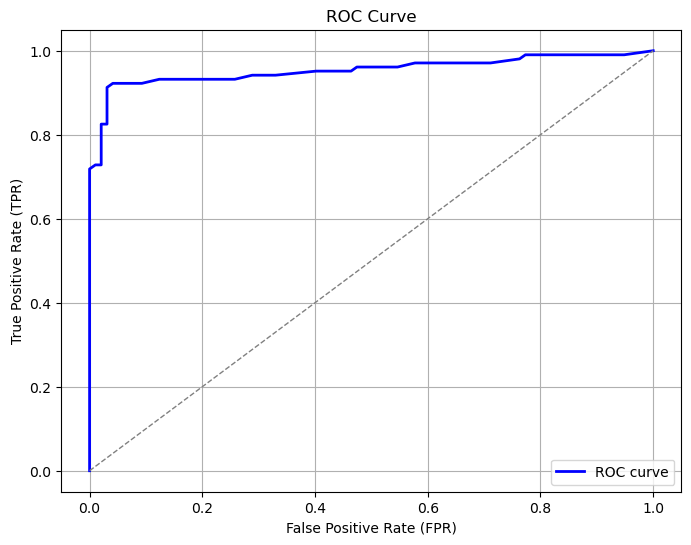

AUROC: 0.9535582023821442


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# Generate some example data
X, y = make_classification(n_samples=1000, n_features=25, n_classes=2, random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForestClassifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict probabilities of positive class for test data
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compute Area Under the ROC Curve (AUROC)
auroc = roc_auc_score(y_test, y_proba)
print("AUROC:", auroc)


In [49]:
# Assuming clf is your trained RandomForestClassifier model

# Get feature importances
importances = clf.feature_importances_

# Assuming feature_names is a list containing the names of your features
# Adjust this according to your actual feature names or column names
feature_names = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the DataFrame
print(feature_importance_df)

                             Feature  Importance
6                           others_9    0.150188
0                           demog_23    0.137592
3                          others_12    0.105526
4                           others_6    0.085508
29                     demog_40_High    0.046856
21                  Diff_txn_values3    0.037979
11                         others_25    0.037376
17                  sum_transactions    0.036578
5                          others_13    0.034528
7                           others_7    0.029692
23                  Diff_txn_values1    0.028551
20       income_to_transaction_ratio    0.027276
30                      demog_40_low    0.025146
22                  Diff_txn_values2    0.022003
10                         others_10    0.021491
13                         others_23    0.021377
25                     demog_43_High    0.017362
9                          others_16    0.015917
12                         others_21    0.015749
2                   

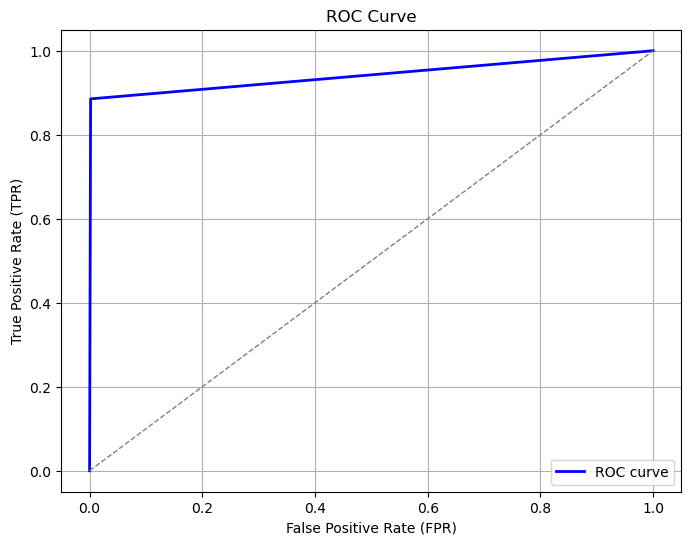

AUROC: 0.9417494692144374


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compute Area Under the ROC Curve (AUROC)
auroc = roc_auc_score(y_test, y_pred)
print("AUROC:", auroc)


In [39]:
num_trees = clf.n_trees

AttributeError: 'RandomForestClassifier' object has no attribute 'n_trees'

In [55]:
# Assuming clf is your trained RandomForestClassifier model

# Get feature importances
importances = clf.feature_importances_

# Assuming feature_names is a list containing the names of your features
# Adjust this according to your actual feature names or column names
feature_names = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the DataFrame
print(feature_importance_df)

                             Feature  Importance
0                           demog_23    0.144714
4                           others_6    0.102809
6                           others_9    0.089652
5                          others_13    0.082738
3                          others_12    0.080191
28                     demog_40_High    0.055887
7                           others_7    0.048373
21                  Diff_txn_values3    0.037660
17                  sum_transactions    0.034942
11                         others_25    0.032504
20       income_to_transaction_ratio    0.031874
22                  Diff_txn_values2    0.031555
29                      demog_40_low    0.027328
13                         others_23    0.021616
10                         others_10    0.020649
8                          others_15    0.016766
12                         others_21    0.015606
18               volume_transactions    0.015184
2                           demog_24    0.015050
24                  